In [ ]:
# !pip install dask[dataframe]
# !sudo apt-get install graphviz graphviz-dev
# !sudo apt-get install build-essential
# !pip install pygraphviz
# !pip install dowhy==0.8
# !pip install econml

In [ ]:
from copy import deepcopy
import json
import time

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import dowhy
from dowhy import CausalModel

from econml.metalearners import SLearner, XLearner, TLearner
from econml.dml import LinearDML, CausalForestDML, DML
from econml.dr import DRLearner, SparseLinearDRLearner

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [33]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Dataset

The data comes from a randomized email experiment on 64,000 customers. The treatment has three levels and was administered randomly:

- 1/3 of the customers received an email campaign featuring **men’s merchandise** (treatment 1)
- 1/3 received an email campaign featuring **women’s merchandise** (treatment 2)
- 1/3 received **no campaign** (control)

### Features:
The features include:
- **Recency**: Time since the last purchase.
- **History**: The amount of dollars spent in the past year.
- **Merchandise Type**: Indicators of the type of merchandise bought in the past year (men’s or women’s).
- **Newbie**: An indicator of whether the customer was new in the past 12 months.
- **Channel**: The channel they purchased from previously.
- **Area**: The type of area they live in (rural, suburban, urban; captured via `zip_code`).

### Treatment:
- The treatment is a **three-level discrete variable** describing which email campaign the customer received (men’s, women’s, or control).

### Outcome Variables:
- **Visit**: Whether the customer visited the site.
- **Conversion**: Whether the customer made a purchase.
- **Spending**: The amount the customer spent.

We’ll use **spending** as our target. It records a customer’s spending within the two weeks following the delivery of the email campaign.

Note: This is an experimental data hence we do not need to define causal graphs

In [ ]:
# Read in the data
hillstrom_clean = pd.read_csv(r'./data/hillstrom_clean.csv')

# Read in labels mapping
with open(r'./data/hillstrom_clean_label_mapping.json', 'r') as f:
    hillstrom_labels_mapping = json.load(f)

In [ ]:
hillstrom_clean.head()

,recency,history,mens,womens,newbie,visit,conversion,spend,zip_code__rural,zip_code__surburban,zip_code__urban,channel__multichannel,channel__phone,channel__web,treatment
0,10,142.44,1,0,0,0,0,0.0,0,1,0,0,1,0,1
1,6,329.08,1,1,1,0,0,0.0,1,0,0,0,0,1,0
2,7,180.65,0,1,1,0,0,0.0,0,1,0,0,0,1,1
3,9,675.83,1,0,1,0,0,0.0,1,0,0,0,0,1,2
4,2,45.34,1,0,0,0,0,0.0,0,0,1,0,0,1,1


In [ ]:
# Drop redundant cols to avoid multicollinearity
hillstrom_clean = hillstrom_clean.drop(['zip_code__urban', 'channel__web'], axis=1)

In [ ]:
# Get sample size
sample_size = hillstrom_clean.shape[0]

In [ ]:
# Split data
hillstrom_X = hillstrom_clean.drop(['visit', 'conversion', 'spend', 'treatment'], axis=1)
hillstrom_Y = hillstrom_clean['spend']
hillstrom_T = hillstrom_clean['treatment']

In [ ]:
# Let’s check how many people bought something under both treatments:
((hillstrom_Y[hillstrom_T > 0] > 0).sum()/sample_size)*100

0.7125

In [27]:
hillstrom_labels_mapping

{'control': 0, 'womans_email': 1, 'mens_email': 2}

# Check how random is the treatment assignment
We cannot fully test whether randomization was valid (there is no easy way to spot arbitrary unobserved
confounding), but we can test whether observed variables can predict treatment. If this were the case,
we’d have an indicator that the randomization or data collection process was flawed.

In [ ]:
# P(T=t)
hillstrom_T.value_counts() / sample_size

,count
treatment,
1,0.334172
2,0.332922
0,0.332906


All values are close to 33.3%, which indicates that the treatments were distributed uniformly

In [ ]:
# Train-test split
X_train_eda, X_test_eda, T_train_eda, T_test_eda = train_test_split(hillstrom_X, hillstrom_T, test_size=.5)

In [ ]:
T_test_eda.value_counts() / T_test_eda.shape[0]

,count
treatment,
0,0.333969
1,0.333625
2,0.332406


In [ ]:
# Fit the EDA model
lgbm_eda = LGBMClassifier()
lgbm_eda.fit(X_train_eda, T_train_eda)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 9
[LightGBM] [Info] Start training from score -1.103091
[LightGBM] [Info] Start training from score -1.094465
[LightGBM] [Info] Start training from score -1.098300


LGBMClassifier()

If there’s no confounding in the data, we expect to get an accuracy of around 33%. The result is as follows:

In [ ]:
# Get predictions on the test
T_pred_eda = lgbm_eda.predict(X_test_eda)

# Check accuracy
acc_eda = accuracy_score(T_test_eda, T_pred_eda)
acc_eda

0.333

# Uplift Modelling

In [ ]:
# Train test split
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
    hillstrom_X,
    hillstrom_Y,
    hillstrom_T,

    # Set test size to 0.5 due to the low conversion rate despite having 64,000 observations.
    test_size=.5

)

In [ ]:
# How many observations in train/test converted?
(y_train[T_train > 0] > 0).sum(), (y_test[T_test > 0] > 0).sum()

(235, 221)

In [ ]:
def create_model(model_type, n_estimators=100, max_depth=10, learning_rate=.01):
    if model_type == 'regressor':
        return LGBMRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate)
    elif model_type == 'classifier':
        return LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate)
    else:
        raise NotImplementedError(f'Model type `{model_type}` not implemented.')

In [ ]:
# Models
s_learner = SLearner(
    overall_model=create_model('regressor')
)

x_learner = XLearner(
    models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ],
    cate_models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ]
)

t_learner = TLearner(
    models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ]
)

dml = LinearDML(
    model_y=create_model('regressor'),
    model_t=create_model('classifier'),
    discrete_treatment=True,
    cv=5
)

dr = DRLearner(
    model_propensity=LogisticRegression(),
    model_regression=create_model('regressor'),
    model_final=create_model('regressor'),
    cv=5,
)

cf = CausalForestDML(
    model_y=create_model('regressor'),
    model_t=create_model('classifier'),
    discrete_treatment=True,
    cv=5
)

In [ ]:
# Models
models = {
    'SLearner': s_learner,
    'TLearner': t_learner,
    'XLearner': x_learner,
    'DRLearner': dr,
    'LinearDML': dml,
    'CausalForestDML': cf
}

In [ ]:
# Fit the estimator
for model_name, model in models.items():
    start = time.time()
    print(f'Fitting {model_name}')
    model.fit(
        Y=y_train,
        T=T_train,
        X=X_train
    )
    stop = time.time()

    print(f'{model_name} fitted in {stop - start:0.4f} seconds.\n')

In [ ]:
# Compute effects
effects_train = {
    'treatment_1': {},
    'treatment_2': {}
}

effects_test = {
    'treatment_1': {},
    'treatment_2': {}
}

for treatment in [1, 2]:
    for model_name, model in tqdm(models.items()):

        # Compute effects on train
        effects_local_train = models[model_name].effect(X_train.values, T0=0, T1=treatment)
        effects_train[f'treatment_{treatment}'][model_name] = effects_local_train

        # Compute effects on test
        effects_local_test = models[model_name].effect(X_test.values, T0=0, T1=treatment)
        effects_test[f'treatment_{treatment}'][model_name] = effects_local_test

100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


In [30]:
effects_train[f'treatment_2']['SLearner']

array([-0.03401087,  0.14735779,  0.38004184, ...,  0.17396308,
        3.3081372 ,  0.01091379])

## Uplift by decile


In [37]:
def get_uplift_by_decile(uplifts, t_true, t_pred, y_true):

    # Encapsulate the data & sort according to uplifts
    all_data = pd.DataFrame(
        dict(
            uplifts=uplifts,
            y_true=y_true,
            t_true=t_true)
    ).query(f't_true==0 | t_true=={t_pred}').sort_values('uplifts')

    # Partition into deciles
    all_data['deciles'] = pd.qcut(all_data['uplifts'], q=10, labels=np.arange(10), duplicates='raise')

    # Get mean responses within deciles
    mean_decile_resp = all_data.groupby(['deciles', 't_true'],observed=True).mean()

    # Compute true decile uplift
    mean_decile_resp['true_uplift'] = mean_decile_resp['y_true'] * np.array([-1, 1]*10)
    true_uplift = mean_decile_resp.groupby(level=[0],observed=True).sum()['true_uplift']

    return true_uplift[::-1]

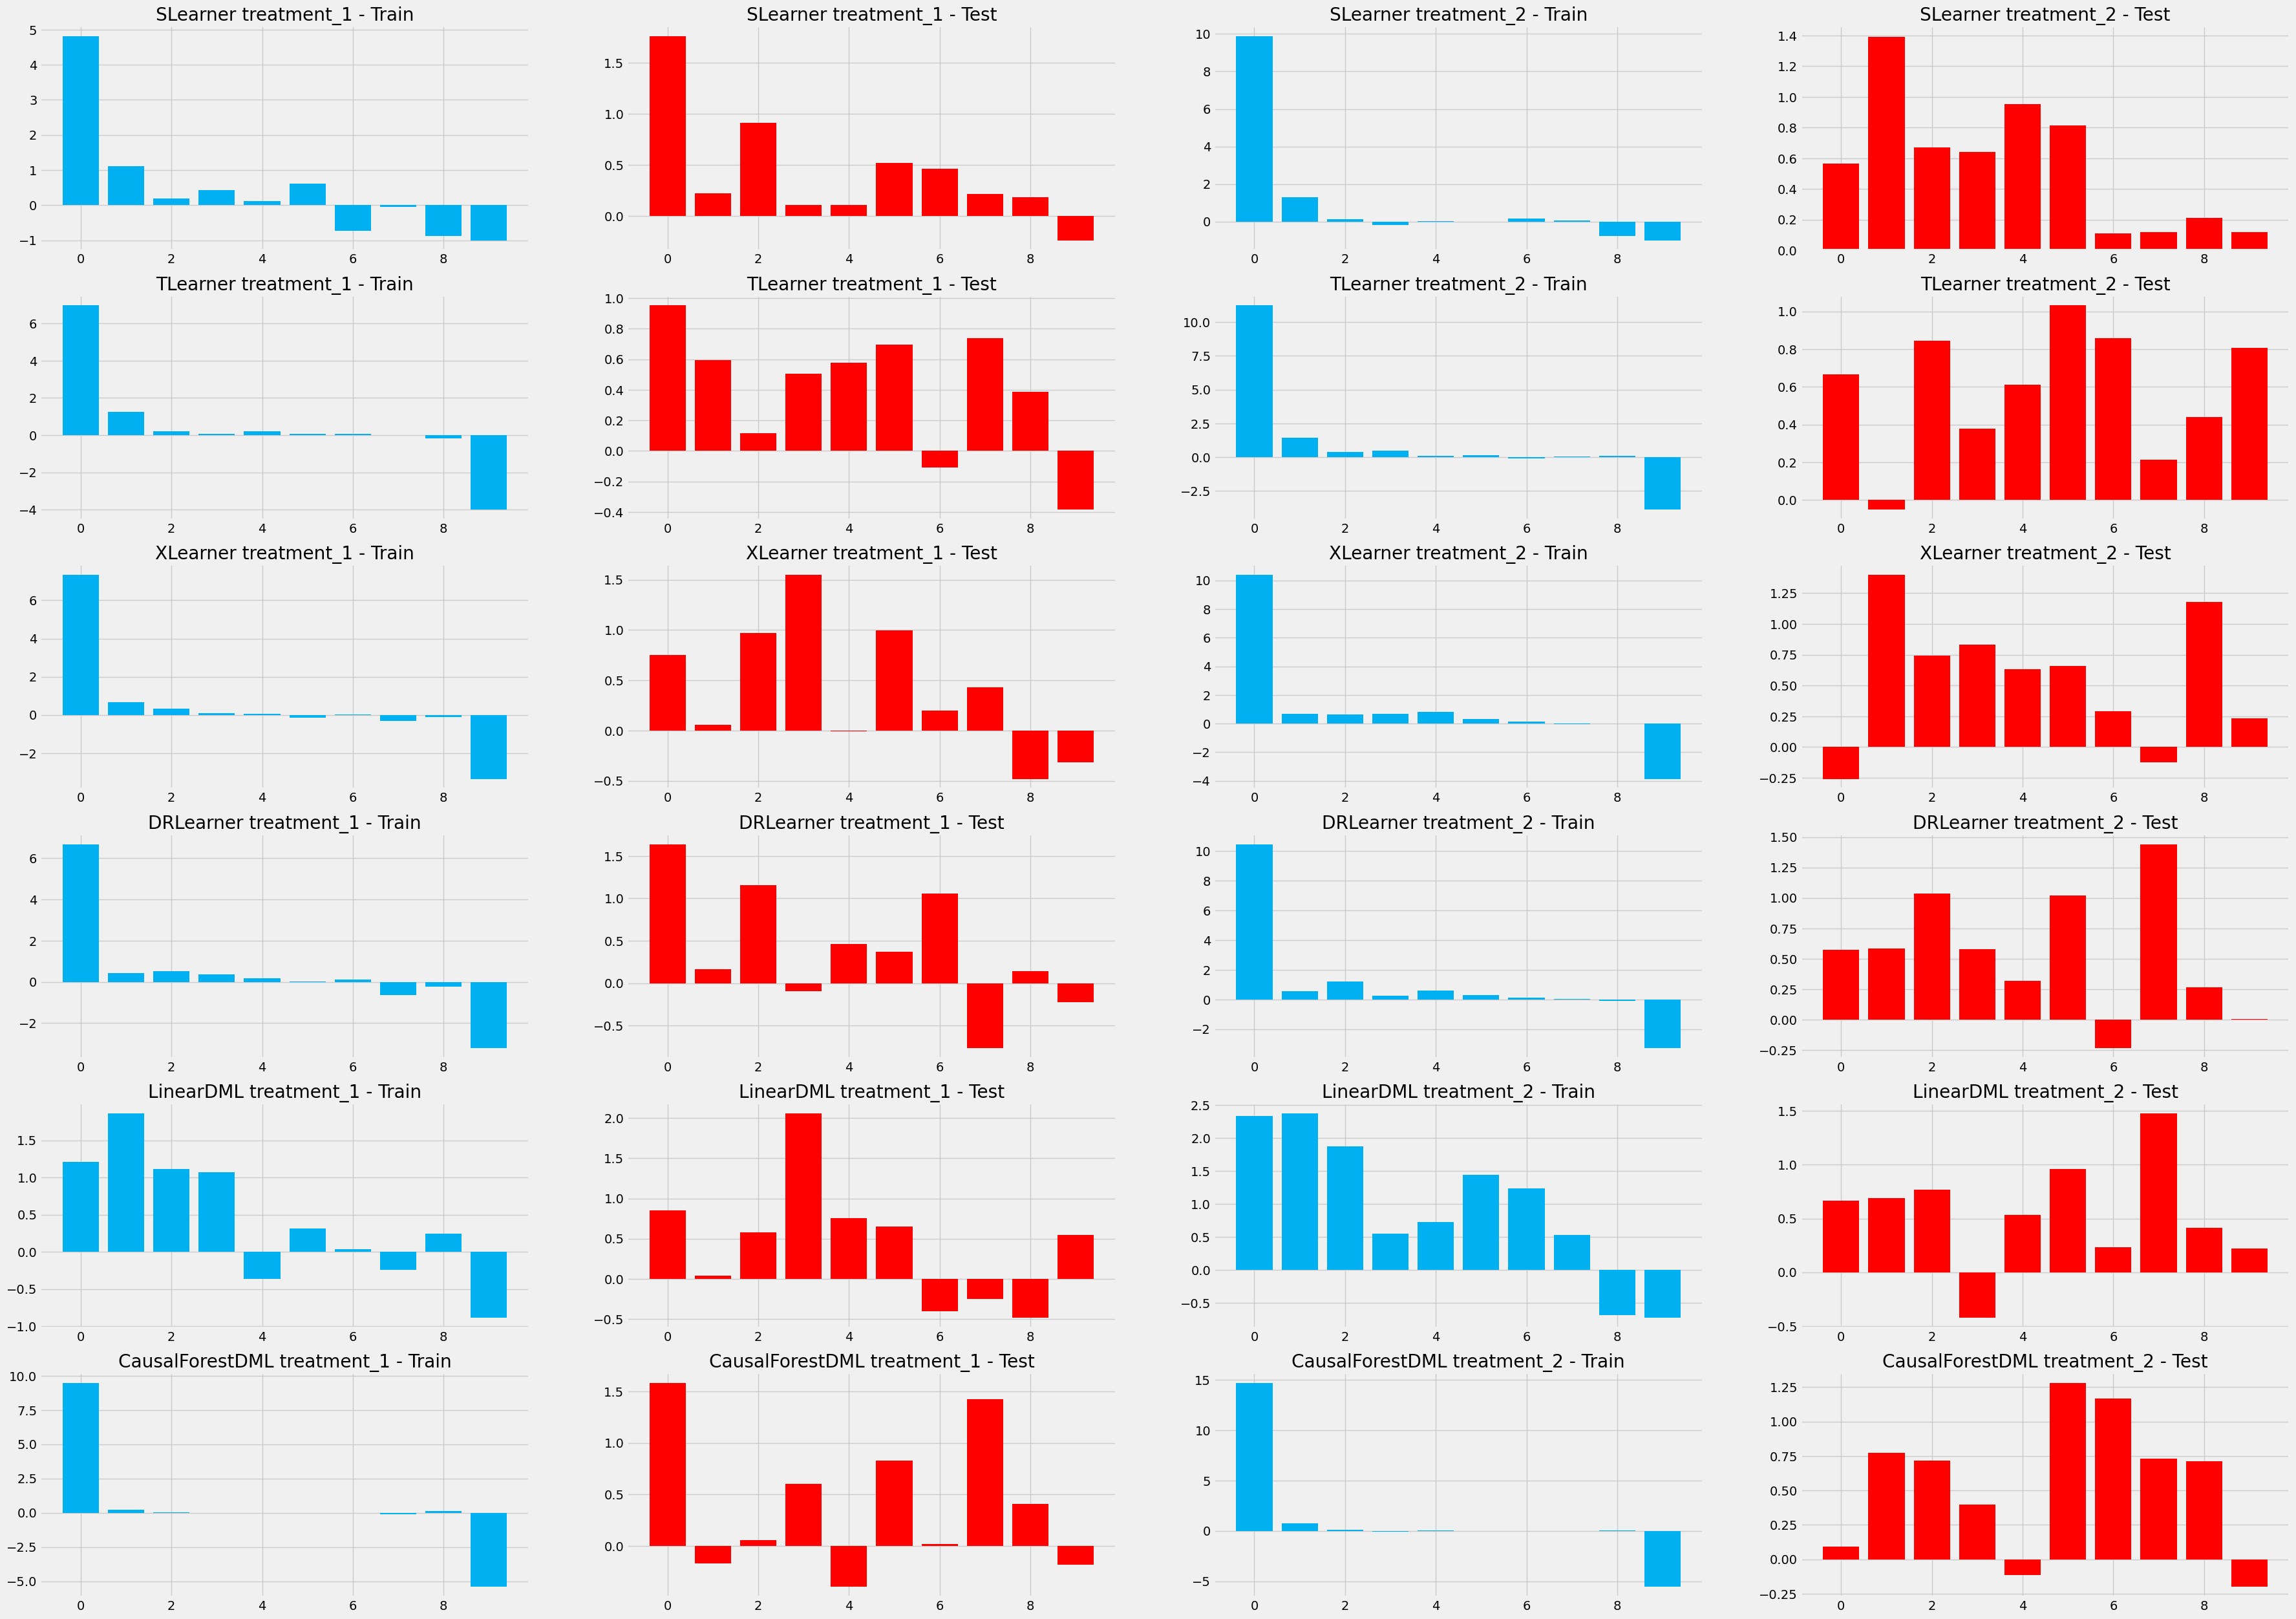

In [38]:
plt.figure(figsize=(40, 30))

i = 1

for model_name in models.keys():

    uplifts_by_decile = {
        'treatment_1': {},
        'treatment_2': {}
    }

    global_min = np.inf
    global_max = -np.inf

    for treatment in ['treatment_1', 'treatment_2']:

        uplift_by_decile_train = get_uplift_by_decile(
            uplifts=effects_train[treatment][model_name],
            t_true=T_train,
            t_pred=int(treatment.split('_')[-1]),
            y_true=y_train
        )

        uplift_by_decile_test = get_uplift_by_decile(
            uplifts=effects_test[treatment][model_name],
            t_true=T_test,
            t_pred=int(treatment.split('_')[-1]),
            y_true=y_test
        )

        plt.subplot(6, 4, i)
        plt.bar(np.arange(10), uplift_by_decile_train, color=COLORS[0])
        plt.title(f'{model_name} {treatment} - Train')

        plt.subplot(6, 4, i + 1)
        plt.bar(np.arange(10), uplift_by_decile_test, color=COLORS[1])
        plt.title(f'{model_name} {treatment} - Test')

        i += 2

plt.show()

### Model Performance Analysis

- In a perfect model, the y-axis values should decrease monotonically from left to right.
- Most models perform well on the training data, except for linear DML, which shows a less clear downward pattern.
- Performance on the test set significantly drops for most models, indicating poor performance in many instances.

#### Possible Reasons for Poor Test Set Performance:
- **Overfitting**: Models may be overfitting to the training data due to insufficient data for generalization.
- **Complex Architectures**: The chosen model architectures may be too complex for the task, as hyperparameters were selected arbitrarily without tuning.
- **Instability**: There may be instability in per-decile estimates of true uplift; however, results on the training set suggest this is likely not the main issue.

- Despite unfavorable uplift per decile plots, this does not necessarily imply that the models are not useful.


### Expected Response

- The method is effective in multiple-treatment scenarios and with continuous outcomes, making it suitable for our case.
- Although the metric focuses on the outcome rather than uplift, it is a valid way to evaluate uplift models.
- The metric computes the expected average outcome by combining information from all treatments, which is convenient.
- It aids decision-making by providing insights into the expected return on investment when employing a chosen model.
  
#### How the Metric Works:
- The metric evaluates uplift models using previously unseen data to check the expected return on investment for a given model.
- It allows for the comparison of two or more models under unconfoundedness, helping to assess expected out-of-sample performance.

#### Calculation Process:
- For each observation in the test set, the method checks if the predicted treatment matches the actual treatment:
  - If they match, the outcome value is divided by the treatment probability and stored.
  - If they do not match, the outcome value is set to 0 and stored.
- The final expected response score is obtained by averaging the stored values.

- This process results in a treatment-weighted average outcome that reflects the expected results when administering treatments according to the model's recommendations.


#### Expected response

As introduced by [Zhao et al., 2017](https://arxiv.org/pdf/1705.08492.pdf)

Formula:

$$\Large Z = \sum_{t=0}^K \frac{1}{P(T=t)}y \mathbb{I}_{h(x)=t}\mathbb{I}_{T=t}$$

<br>


* $K$ is a number of treatment levels

* $\mathbb{I}$ is an indicator function

* $h(x)$ is the treatment recommended by the model (treatment leading to the highest uplift)

In [39]:
def get_effects_argmax(effects_arrays, return_matrix=False):
    """Returns argmax for each row of predicted effects for the arbitrary no. of treatments.

    :param effects_arrays: A list of arrays for K treatments, where K>=1 (without control null effects)
    :type effects_arrays: list of np.arrays

    :param return_matrix: Determines if the function returns a matrix of all effects
        (with added null effect for control)
    :type return_matrix: bool

    ...
    :return: A stacked matrix of all effects with added column for control effects (which is always 0)
    :rtype: np.array
    """

    n_rows = effects_arrays[0].shape[0]
    null_effect_array = np.zeros(n_rows)
    stacked = np.stack([null_effect_array] + effects_arrays).T

    if return_matrix:
        return np.argmax(stacked, axis=1), stacked

    return np.argmax(stacked, axis=1)


def get_expected_response(y_true, t_true, effects_argmax):
    """Computes the average expected response for an uplift model according to the formula
        proposed by:
        Zhao, Y., Fang, X., & Simchi-Levi, D. (2017). Uplift Modeling with Multiple Treatments and General Response Types.
        Proceedings of the 2017 SIAM International Conference on Data Mining, 588-596.
        Society for Industrial and Applied Mathematics.
    """

    proba_t = pd.Series(t_true).value_counts() / np.array(t_true).shape[0]
    treatments = proba_t.index.values

    z_vals = 0

    for treatment in treatments:
        h_indicator = effects_argmax == treatment
        t_indicator = t_true == treatment
        t_proba_local = proba_t[treatment]

        z_vals += (1/t_proba_local) * y_true * h_indicator * t_indicator

    return z_vals.mean()

In [40]:
# Compute expected response
print('Expecetd response on train:\n')
for model_name in models:
    effects_argmax = get_effects_argmax(
        [
            effects_train['treatment_1'][model_name],
            effects_train['treatment_2'][model_name]
        ]
    )

    expected_response = get_expected_response(
        y_true=y_train,
        t_true=T_train,
        effects_argmax=effects_argmax
    )

    print(f'{model_name}: {expected_response}')

print('\n' + '-'*30)

print('Expected response on test:\n')
for model_name in models:
    effects_argmax = get_effects_argmax(
        [
            effects_test['treatment_1'][model_name],
            effects_test['treatment_2'][model_name]
        ]
    )

    expected_response = get_expected_response(
        y_true=y_test,
        t_true=T_test,
        effects_argmax=effects_argmax
    )

    print(f'{model_name}: {expected_response}')

Expecetd response on train:

SLearner: 2.0060728511208303
TLearner: 2.5664315114890086
XLearner: 2.480725861392331
DRLearner: 2.4140679034196624
LinearDML: 1.7791097624207983
CausalForestDML: 3.0201937252279754

------------------------------
Expected response on test:

SLearner: 1.3738163652693984
TLearner: 1.2612518694273493
XLearner: 1.3494207988032367
DRLearner: 1.383286150438881
LinearDML: 1.3114465589959847
CausalForestDML: 1.2707989238075792


The best model on the test set according to the expected response is DR-Learner.

## Confidence intervals

In [41]:
models['LinearDML'].effect_interval(X=X_test, T0=0, T1=1)

(array([-0.93008459, -1.01275935, -0.46354002, ..., -0.73806378,
        -0.77662255, -1.42950942]),
 array([0.9168186 , 0.86156841, 1.38650105, ..., 1.37953677, 1.42268821,
        0.27053434]))

In [46]:
models['LinearDML'].effect_interval(X=X_test.iloc[0:1, :], T0=0, T1=1)

(array([-0.93008459]), array([0.9168186]))